In [1]:
import sys
sys.path.append('/usr/src/data/')
import os
os.chdir('/usr/src/data/')
import Env_0 as env

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
from stable_baselines3.common.env_checker import check_env

### Init

In [2]:
env = env.robotEnv("/usr/src/data/configuration.yaml")

/usr/src/data


In [ ]:
check_env(env, warn=True)

#### Utilites

In [ ]:
def compute_camera_matrix():
  model = env.simulator.model
  data = env.simulator.data
  renderer = env.simulator.renderer
  renderer.update_scene(data,camera="top_down")
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
  rot = np.vstack((np.cross(y, z), y, z))
  fov = model.cam('top_down').fovy[0]

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos

  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (renderer.width - 1) / 2.0
  image[1, 2] = (renderer.height - 1) / 2.0
  return image @ focal @ rotation @ translation

def word2pixel(xyz_global):
    cam_matrix = compute_camera_matrix()
    # Camera matrices multiply homogenous [x, y, z, 1] vectors.
    corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
    corners_homogeneous[:3, :] = xyz_global
    # Get the camera matrix.
    xs, ys, s = cam_matrix @ corners_homogeneous
    # x and y are in the pixel coordinate system.
    x = xs / s
    y = ys / s
    return x,y


def normalizeAngle(angle):
    if(angle>np.pi):angle -=np.pi
    elif(angle<0):angle += np.pi
    return angle


def get_objs(): # list(x,y,rot)
    initialObjPos=[]
    for i in range(env.simulator.configs["NUMBER_OF_OBJECTS"]):
        # get the position of the obj from the site in the right position (+1 due to the target (goal) site)
        coords = env.simulator.data.site(1+i).xpos.copy()
        pixelCoord = word2pixel(np.array([coords[0],coords[1],coords[2]]).reshape(3,1))
        rot = Rotation.from_quat(env.simulator.data.qpos[0+7*i+3:7*(i+1)].copy()).as_euler('xyz')
        rot = normalizeAngle(2.35+rot[0])
        initialObjPos.append((pixelCoord[0][0],pixelCoord[1][0],rot))
    return initialObjPos


def showObs(obs):
    plt.imshow(obs.transpose(1,2,0))
    plt.gray()
    plt.show()


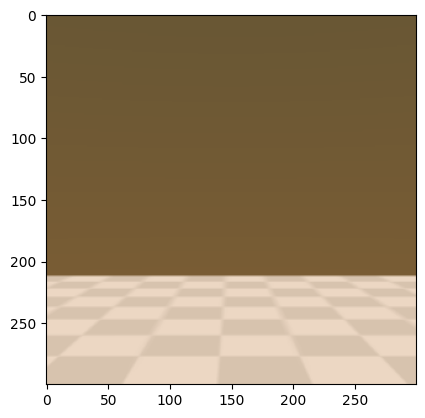

In [3]:
#plot camera frame
env.simulator.renderer.update_scene(env.simulator.data, camera="angled_side_view")
frame = env.simulator.renderer.render()
plt.imshow((frame * 255).astype(np.uint8))


### Random Action


In [3]:
# perform a random action
env.reset()
action = env.action_space.sample()
print("action:",action)
action = np.array(action)
obs,rew,done,_,_ = env.step(action)

print("done:",done) 
print("reward:",rew,"\n")

if(done): env.reset()

# print the obs after the action
#showObs(env.current_obs)

action: [ 0.83030164 -0.76818776 -0.4333688 ]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Initial Joint Position: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Object Position: [-0.35831002  0.19676381  0.11      ]


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (300, 300) to (304, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to simulated_pick.mp4
done: False
reward: -1 



### Pick Objs

In [5]:
env.reset()
obj = get_objs()
obj_to_pick= env.simulator.constants["NUMBER_OF_OBJECTS"]

for i in range(obj_to_pick):
    #normalize the coordinates between [-1,1]
    coordinates = np.array(obj[i][0:2])/(env.simulator.constants["OBSERVATION_IMAGE_DIM"]/2) -1 
    rot = obj[i][2]/(np.pi/2)-1

    obs, reward, done,_,info = env.step(np.append(coordinates,rot))
    print("Rew:",reward)
    print("done",done)
    

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Initial Joint Position: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Object Position: [-0.30568702  0.33956615  0.11      ]


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (300, 300) to (304, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to simulated_pick.mp4
Rew: -0.135
done False
[1.345147049298509, -0.7261200437459273, -0.7708851603895234, 0.016439544460273705, 1.6386114584982074, 0.35004224576676224]
Initial Joint Position: [ 0.          1.34514705 -0.72612004 -0.77088516  0.01643954  1.63861146
  0.35004225  0.          0.        ]
Object Position: [-0.32235223  0.36225582  0.11      ]


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (300, 300) to (304, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to simulated_pick.mp4
Rew: -0.07799999999999996
done False


In [ ]:
import imageio

def gray2rgb( gray):
    # If input is shape (1, H, W), squeeze to (H, W)
    gray = np.squeeze(gray) * 255.0  # De-normalize

    # Replicate grayscale across RGB channels
    rgb = np.stack([gray]*3, axis=-1)  # shape = (H, W, 3)
    return rgb.astype(np.uint8)

# Open video writer
writer = imageio.get_writer('mujoco_output.mp4', fps=30)

# Simulate and record frames
for _ in range(10):  # ~10 seconds at 30fps
    coordinates = np.array(obj[i][0:2])/(env.simulator.constants["OBSERVATION_IMAGE_DIM"]/2) -1 
    rot = obj[i][2]/(np.pi/2)-1

    obs, reward, done,_,info = env.step(np.append(coordinates,rot))

# Clean up
writer.close()
print("Video saved as mujoco_output.mp4")

[1.3613407883153257, -0.7074216398927289, -0.8011015724486786, -0.014417523430305324, 1.6429533734444914, -2.5400701540422745]
Initial Joint Position: [ 0.          1.36134079 -0.70742164 -0.80110157 -0.01441752  1.64295337
 -2.54007015  0.          0.        ]
Object Position: [-0.27271192  0.42366434  0.20252   ]


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (300, 300) to (304, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[1.3629148299816531, -0.717996867172924, -0.7840435923834903, -0.01741642375308249, 1.641211222504462, -3.047001544659546]
Initial Joint Position: [ 0.          1.36291483 -0.71799687 -0.78404359 -0.01741642  1.64121122
 -3.04700154  0.          0.        ]
Object Position: [-0.27271192  0.42366434  0.20252   ]
[1.3609010027293658, -0.7059794137119929, -0.8034215360106548, -0.013579316167174508, 1.6431937817048052, -2.4600262613682475]
Initial Joint Position: [ 0.          1.360901   -0.70597941 -0.80342154 -0.01357932  1.64319378
 -2.46002626  0.          0.        ]
Object Position: [-0.27271192  0.42366434  0.20252   ]
[1.36293425727632, -0.7217216299385909, -0.7780159778046914, -0.01745273460125515, 1.6406186439987223, -3.2131050060753914]
Initial Joint Position: [ 0.          1.36293426 -0.72172163 -0.77801598 -0.01745273  1.64061864
 -3.21310501  0.          0.        ]
Object Position: [-0.27271192  0.42366434  0.20252   ]
[1.3611078940165542, -0.7066284240723266, -0.80237772799